In [3]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import hvplot.pandas
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [4]:
# Reading Congress csv

transactions_df = pd.read_csv("Congress Transactions 2021-2022.csv")

In [5]:
# Create a list of congress people on the csv
representatives_list = transactions_df.representative.values.tolist()

# Remove duplicates from the list
reps_no_dups = [*set(representatives_list)]

# Choose number of random reps from the list - here we are choosing 6  
random_reps = random.sample(reps_no_dups, 6)

In [6]:
rand_reps_transactions = transactions_df[transactions_df['representative'].isin(random_reps)]

In [7]:
# Set type of transaction to purchase only

rand_reps_transactions = transactions_df[transactions_df['representative'].isin(random_reps)]
rand_reps_purchases = rand_reps_transactions[rand_reps_transactions["type"]=="purchase"]
rand_reps_purchases.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
2837,2021,07/26/2021,2021-06-11,joint,FTTGLX,First Trust High Income Model,purchase,"$250,001 - $500,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
4397,2021,05/24/2021,2021-05-07,joint,AI,C3 AI Inc,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
5081,2022,12/05/2022,2022-11-02,joint,--,US Treasury Notes,purchase,"$500,001 - $1,000,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
6067,2021,09/10/2021,2021-08-20,self,COST,CostCo Wholesale,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,Department/Specialty Retail Stores,Consumer Services,Republican
6068,2021,09/10/2021,2021-08-20,NaN,COST,CostCo Wholesale,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,Department/Specialty Retail Stores,Consumer Services,Republican


In [8]:
# Random Representative and Party

rand_rep_party = rand_reps_transactions[["representative","party"]]
rand_rep_party = rand_rep_party.drop_duplicates().reset_index()
rand_rep_party_index = rand_rep_party.set_index(["representative"])["party"]
pd.DataFrame(rand_rep_party_index)

,party
representative,
Fred Upton,Republican
Greg Francis Murphy,Republican
Ashley Hinson Arenholz,Republican
John Garamendi,Democrat
Abigail Spanberger,Democrat
Justin Amash,Libertarian


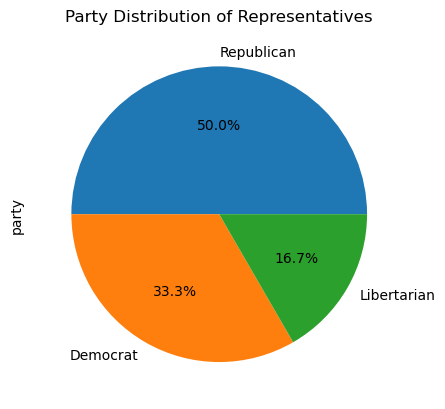

In [9]:
# Random Representative % of Party

party_counts = rand_rep_party_index.value_counts()

party_counts.plot.pie(autopct='%.1f%%')
plt.title('Party Distribution of Representatives')
plt.show()

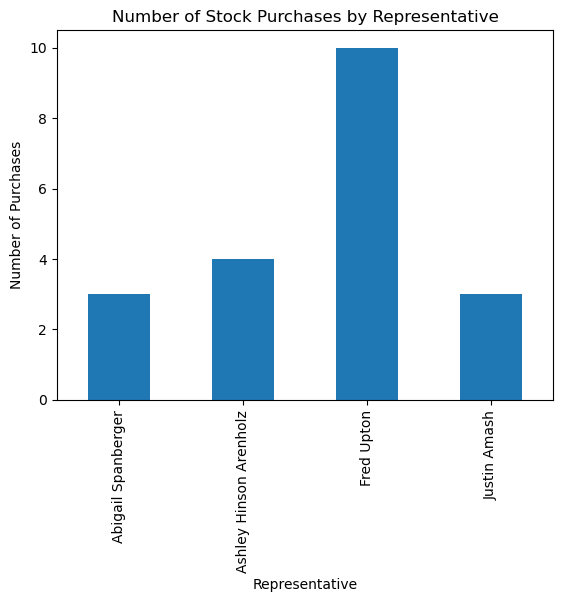

In [10]:
# Bar Chart for Number of Stock Purchases per Representative

number_purchases= rand_reps_purchases.groupby(["representative"]).count()["type"]
number_purchases.plot(kind="bar")
plt.xlabel("Representative")
plt.ylabel("Number of Purchases")
plt.title("Number of Stock Purchases by Representative")
plt.show()

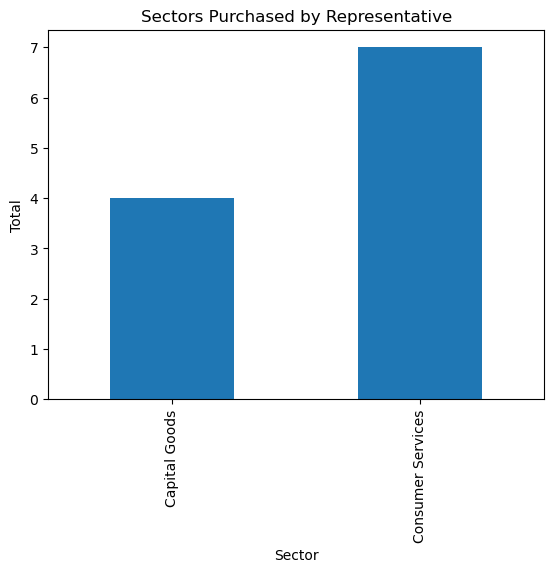

In [11]:
# Sectors purchased by random representatives

top_sectors= rand_reps_purchases.groupby(["sector"]).count()["representative"]
top_sectors.plot(kind="bar")
plt.xlabel("Sector")
plt.ylabel("Total")
plt.title("Sectors Purchased by Representative")
plt.show()

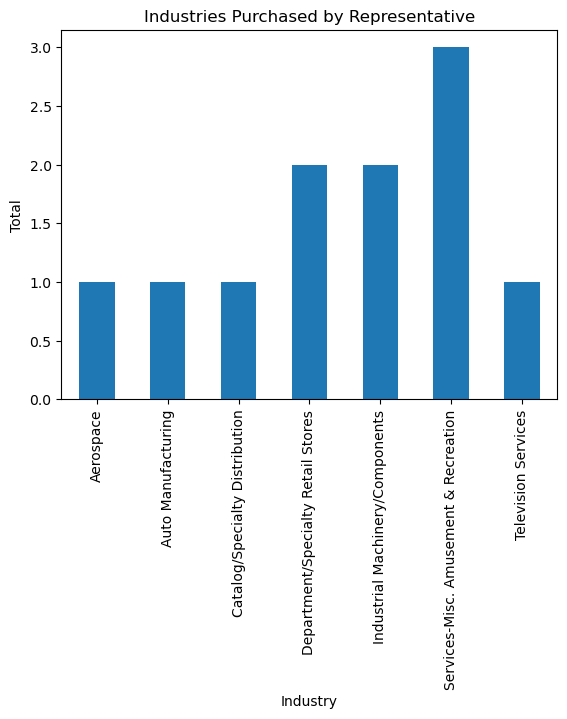

In [12]:
# Representative and Industry

top_sectors= rand_reps_purchases.groupby(["industry"]).count()["representative"]
top_sectors.plot(kind="bar")
plt.xlabel("Industry")
plt.ylabel("Total")
plt.title("Industries Purchased by Representative")
plt.show()

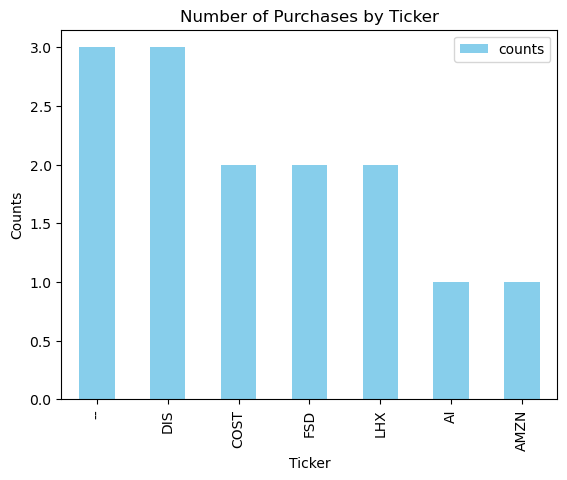

In [13]:
# Top seven tickers purchased by all representatives

tickers_purchased = rand_reps_purchases.groupby("ticker").size().reset_index(name='counts')
tickers_purchased = tickers_purchased.sort_values("counts", ascending=False).head(7)
tickers_purchased.plot(kind='bar', x='ticker', y='counts', color='skyblue')
plt.xlabel('Ticker')
plt.ylabel('Counts')
plt.title('Number of Purchases by Ticker')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Representative state to be mapped in hvplot

rep_state = rand_reps_transactions[["representative","state"]]
rep_state = rep_state.drop_duplicates().reset_index()
rep_state_index = rep_state.set_index(["representative"])["state"]
pd.DataFrame(rep_state)

,index,representative,state
0,1301,Fred Upton,MI
1,6381,Greg Francis Murphy,NC
2,6469,Ashley Hinson Arenholz,IA
3,9531,John Garamendi,CA
4,10583,Abigail Spanberger,VA
5,16402,Justin Amash,MI


In [15]:
# Adding lat and long to map in hvplot

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

rep_state['latitude'] = None
rep_state['longitude'] = None

for i, row in rep_state.iterrows():
    location = geolocator.geocode(row["state"] + ', United States')
    rep_state.at[i, 'latitude'] = location.latitude
    rep_state.at[i, 'longitude'] = location.longitude

rep_state

ModuleNotFoundError: No module named 'geopy'

In [ ]:
merged_df = pd.merge(rep_state, number_purchases, on='representative')
merged_df

In [ ]:
# Plot representative state and number of purchases on US map

rep_map = merged_df.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    hover_cols = ["representative","type"]
)

# Display the map plot
rep_map

In [16]:
# Get tickers from all transactions for each of the random congress people chosen above
rand_reps_transactions = transactions_df[transactions_df['representative'].isin(random_reps)]
# Set type of transaction to purchase only
rand_reps_purchases = rand_reps_transactions[rand_reps_transactions["type"]=="purchase"]
rand_reps_purchases

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party
2837,2021,07/26/2021,2021-06-11,joint,FTTGLX,First Trust High Income Model,purchase,"$250,001 - $500,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
4397,2021,05/24/2021,2021-05-07,joint,AI,C3 AI Inc,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
5081,2022,12/05/2022,2022-11-02,joint,--,US Treasury Notes,purchase,"$500,001 - $1,000,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
6067,2021,09/10/2021,2021-08-20,self,COST,CostCo Wholesale,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,Department/Specialty Retail Stores,Consumer Services,Republican
6068,2021,09/10/2021,2021-08-20,NaN,COST,CostCo Wholesale,purchase,"$15,001 - $50,000",Fred Upton,MI06,MI,https://disclosures-clerk.house.gov/public_dis...,False,Department/Specialty Retail Stores,Consumer Services,Republican
6470,2021,04/05/2021,2021-03-08,self,AMZN,Amazon.com Inc,purchase,"$1,001 - $15,000",Ashley Hinson Arenholz,IA01,IA,https://disclosures-clerk.house.gov/public_dis...,False,Catalog/Specialty Distribution,Consumer Services,Republican
6476,2021,04/05/2021,2021-03-05,self,--,High Street Insurance partners,purchase,"$250,001 - $500,000",Ashley Hinson Arenholz,IA01,IA,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican
6478,2021,04/05/2021,2021-03-31,self,QCHR,QCR Holdings Inc,purchase,"$1,001 - $15,000",Ashley Hinson Arenholz,IA01,IA,https://disclosures-clerk.house.gov/public_dis...,True,NaN,NaN,Republican
6481,2021,04/05/2021,2021-03-04,self,TSLA,Tesla In,purchase,"$1,001 - $15,000",Ashley Hinson Arenholz,IA01,IA,https://disclosures-clerk.house.gov/public_dis...,False,Auto Manufacturing,Capital Goods,Republican
10583,2021,06/03/2021,2021-06-01,self,LHX,L3Harris Special Stock Grant,purchase,"$1,001 - $15,000",Abigail Spanberger,VA07,VA,https://disclosures-clerk.house.gov/public_dis...,False,Industrial Machinery/Components,Capital Goods,Democrat


In [17]:
#get the tickers for all transactions in the dataframe of transactions for randomly chosen congress people
tickers = rand_reps_purchases.ticker.values.tolist()
#remove duplicates from tickers
tickers = [*set(tickers)]
tickers

['DIS',
 'FTTGLX',
 'COST',
 'FSD',
 'LHX',
 'CHV',
 '--',
 'AMZN',
 'TSLA',
 'QCHR',
 'CHTR',
 'AI',
 'HON']

In [18]:
#tickers to yfinance to get history to get history for specified date range
stock_info = yf.download(tickers, start = "2021-1-1", end = "2022-1-1", ignore_tz=True)
stock_info

[*********************100%***********************]  13 of 13 completed

4 Failed downloads:
- FTTGLX: AttributeError("'NoneType' object has no attribute 'tz_convert'")
- --: No timezone found, symbol may be delisted
- QCHR: No timezone found, symbol may be delisted
- CHV: No data found for this date range, symbol may be delisted


Adj Close                                                      \
                  --          AI        AMZN        CHTR CHV        COST   
Date                                                                       
2021-01-04       NaN  120.010002  159.331497  647.030029 NaN  374.112579   
2021-01-05       NaN  122.169998  160.925507  636.590027 NaN  369.772552   
2021-01-06       NaN  113.400002  156.919006  624.510010 NaN  364.143463   
2021-01-07       NaN  133.580002  158.108002  629.770020 NaN  362.076782   
2021-01-08       NaN  143.630005  159.134995  634.380005 NaN  364.064728   
...              ...         ...         ...         ...  ..         ...   
2021-12-27       NaN   33.200001  169.669495  652.349976 NaN  558.752441   
2021-12-28       NaN   32.389999  170.660995  655.789978 NaN  559.912720   
2021-12-29       NaN   31.459999  169.201004  656.280029 NaN  563.016479   
2021-12-30       NaN   32.580002  168.644501  657.229980 NaN  559.188721   
2021-12-31       NaN   31.250000  166.716995  651.969971 NaN  562.947083   

                                                      ...   Volume      \
                   DIS        FSD FTTGLX         HON  ...     CHTR CHV   
Date                                                  ...                
2021-01-04  177.679993  11.972094    NaN  200.312744  ...  1185200 NaN   
2021-01-05  178.440002  12.004963    NaN  200.804016  ...   842600 NaN   
2021-01-06  179.119995  11.996747    NaN  204.464447  ...  1491400 NaN   
2021-01-07  178.580002  12.078914    NaN  204.801605  ...  1259500 NaN   
2021-01-08  178.690002  12.128219    NaN  202.316360  ...  1051100 NaN   
...                ...        ...    ...         ...  ...      ...  ..   
2021-12-27  152.800003  13.870074    NaN  202.246490  ...   435000 NaN   
2021-12-28  155.199997  13.870074    NaN  202.853928  ...   450700 NaN   
2021-12-29  154.869995  13.878953    NaN  203.324203  ...   533100 NaN   
2021-12-30  155.929993  13.967749    NaN  202.912704  ...   562200 NaN   
2021-12-31  154.889999  13.843434    NaN  204.284332  ...   789400 NaN   

                                                                                
               COST       DIS     FSD FTTGLX      HON      LHX QCHR       TSLA  
Date                                                                            
2021-01-04  3322200  13426600  186300    NaN  2328900  1477100  NaN  145914600  
2021-01-05  2748400   7771800  149200    NaN  2172100  1315900  NaN   96735600  
2021-01-06  2661400   7517800  142800    NaN  2747900  1606200  NaN  134100000  
2021-01-07  2849500   7300800  115700    NaN  2057300  1520800  NaN  154496700  
2021-01-08  2599700   7894500   46000    NaN  3278900  1409000  NaN  225166500  
...             ...       ...     ...    ...      ...      ...  ...        ...  
2021-12-27  2262900   7762000   72500    NaN  2486400   592000  NaN   71145900  
2021-12-28  1155000  12198700   79900    NaN  1971200   537100  NaN   60324000  
2021-12-29  1753000   8737000   58900    NaN  1714500   900800  NaN   56154000  
2021-12-30  1338700   7228400   79200    NaN  1273100   573200  NaN   47040900  
2021-12-31  1509200   6410200  107800    NaN  1536500   587100  NaN   40733700  

[252 rows x 78 columns]

In [19]:
#Copy stock history to a static dataframe so we are not requesting data every time we reference 
stock_static = stock_info["Adj Close"].copy()

#Changing date from index to a column
stock_static.reset_index(inplace=True)
stock_static = stock_static.dropna(axis='columns', how='all')
stock_static

#Have to use this format to access columns
#a = stock_static["Adj Close"]["ACN"].values.tolist()
#a

,Date,AI,AMZN,CHTR,COST,DIS,FSD,HON,LHX,TSLA
0,2021-01-04,120.010002,159.331497,647.030029,374.112579,177.679993,11.972094,200.312744,173.699570,243.256668
1,2021-01-05,122.169998,160.925507,636.590027,369.772552,178.440002,12.004963,200.804016,175.538208,245.036667
2,2021-01-06,113.400002,156.919006,624.510010,364.143463,179.119995,11.996747,204.464447,175.942520,251.993332
3,2021-01-07,133.580002,158.108002,629.770020,362.076782,178.580002,12.078914,204.801605,174.479279,272.013336
4,2021-01-08,143.630005,159.134995,634.380005,364.064728,178.690002,12.128219,202.316360,173.949844,293.339996
...,...,...,...,...,...,...,...,...,...,...
247,2021-12-27,33.200001,169.669495,652.349976,558.752441,152.800003,13.870074,202.246490,206.365067,364.646667
248,2021-12-28,32.389999,170.660995,655.789978,559.912720,155.199997,13.870074,202.853928,208.160583,362.823334
249,2021-12-29,31.459999,169.201004,656.280029,563.016479,154.869995,13.878953,203.324203,208.366592,362.063324
250,2021-12-30,32.580002,168.644501,657.229980,559.188721,155.929993,13.967749,202.912704,208.925873,356.779999


In [26]:
# Create a new DataFrame to hold the stock returns for each stock purchased by the random representative
returns_df = pd.DataFrame()

In [27]:
# Calculate the stock returns for each stock purchased by the random representative
for ticker in tickers:
    returns_df[ticker] = stock_static[ticker].pct_change()

KeyError: 'FTTGLX'

In [28]:
# Drop any rows with missing values from the returns DataFrame
returns_df.dropna(inplace=True)

In [29]:
# Fit an regression model to the stock returns
model = sm.OLS(returns_df[tickers[1]], sm.add_constant(returns_df[tickers[0]])).fit()
# Print the coefficient and intercept of the regression model
print(random_rep)
print(tickers[0])
print(tickers[1])
print("Coefficient: ", model.params[1])
print("Intercept: ", model.params[0])
# Get the p-value for the regression
print("P-value: ", model.pvalues[1])

KeyError: 'FTTGLX'

In [30]:
x = returns_df[tickers[0]].values.reshape(-1, 1)
y = returns_df[tickers[1]].values.reshape(-1, 1)
plt.scatter(x, y, color='blue')
plt.plot(x, reg.predict(x), color='red')
plt.xlabel("Ticker (0) (x)")
plt.ylabel("Ticker (1) (y)")
plt.title("Linear Regression of Stock Purchases")
plt.show()

KeyError: 'FTTGLX'

In [31]:
#Convert the date format to match the Congress dataframe date format
#stock_static = pd.to_datetime(stock_static["Date"], format = '%Y-%m-%d %H:%M:%S').strftime('%m/%d/%Y')
stock_static["New Date"]= stock_static["Date"].dt.strftime('%#m/%d/%Y')
#dff = dff["Old Time"].dt.strftime("%d/%m/%Y %H:%M")
stock_static

,Date,AI,AMZN,CHTR,COST,DIS,FSD,HON,LHX,TSLA,New Date
0,2021-01-04,120.010002,159.331497,647.030029,374.112579,177.679993,11.972094,200.312744,173.699570,243.256668,#m/04/2021
1,2021-01-05,122.169998,160.925507,636.590027,369.772552,178.440002,12.004963,200.804016,175.538208,245.036667,#m/05/2021
2,2021-01-06,113.400002,156.919006,624.510010,364.143463,179.119995,11.996747,204.464447,175.942520,251.993332,#m/06/2021
3,2021-01-07,133.580002,158.108002,629.770020,362.076782,178.580002,12.078914,204.801605,174.479279,272.013336,#m/07/2021
4,2021-01-08,143.630005,159.134995,634.380005,364.064728,178.690002,12.128219,202.316360,173.949844,293.339996,#m/08/2021
...,...,...,...,...,...,...,...,...,...,...,...
247,2021-12-27,33.200001,169.669495,652.349976,558.752441,152.800003,13.870074,202.246490,206.365067,364.646667,#m/27/2021
248,2021-12-28,32.389999,170.660995,655.789978,559.912720,155.199997,13.870074,202.853928,208.160583,362.823334,#m/28/2021
249,2021-12-29,31.459999,169.201004,656.280029,563.016479,154.869995,13.878953,203.324203,208.366592,362.063324,#m/29/2021
250,2021-12-30,32.580002,168.644501,657.229980,559.188721,155.929993,13.967749,202.912704,208.925873,356.779999,#m/30/2021


In [32]:
type(stock_static["New Date"][0])

str

In [33]:
acn_purchases = rand_reps_purchases.loc[rand_reps_purchases['ticker'] == "ABT"]
acn_purchases

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party


In [34]:
# Getting the price data for a specific stock and date
# Purchase_price = stock_static[stock_static["New Date"] =="1/04/2021"]["Adj Close"]["NTAP"]
# Purchase_price

ticker = stock_static["ABT"]
date = stock_static["New Date"]

plt.plot(date, ticker, color='blue', marker='.', linestyle='solid')
plt.axvline("8/03/2021", color = "green")
plt.axvline("5/24/2021", color ="red")


#purchase_price = stock_static[stock_static["New Date"] == "01/04/2021"]["Adj Close"]["AMZN"]


#purchase_date = "01/04/2021"
#purchase_price = stock_static[stock_static["New Date"] == purchase_date]["Adj Close"]["AMZN"]

#plt.plot(purchase_date,purchase_price, marker = "o",color="red")
#transaction = acn_purchases["transaction_date"]


#x = stock_static["Adj Close"]["ABNB"] & date == transaction
#print(x)
#plt.plot(transaction)
#months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']
#plt.xticks(np.linspace(0,365,13), months)



#"= df['date'].apply(pd.Timestamp)
#df=df.set_index('date')
#df.plot(marker='o')

plt.show()

KeyError: 'ABT'